<a href="https://colab.research.google.com/github/wangechi17/sdgmodel/blob/main/sdg_prediction_model_abigail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
pip install gradio pandas plotly scikit-learn matplotlib seaborn numpy

In [ ]:

# Mount Google Drive if your dataset is stored there
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset (adjust path as needed)
file_path = '/content/drive/MyDrive/DATA SETS/UN_SDG.csv'
df = pd.read_csv(file_path)


# Preview
print("Shape of dataset:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of dataset: (53651, 37)


,STRUCTURE,STRUCTURE_ID,ACTION,FREQ,FREQ_LABEL,REF_AREA,REF_AREA_LABEL,INDICATOR,INDICATOR_LABEL,SEX,...,UNIT_MULT,UNIT_MULT_LABEL,UNIT_TYPE,UNIT_TYPE_LABEL,TIME_FORMAT,TIME_FORMAT_LABEL,OBS_STATUS,OBS_STATUS_LABEL,OBS_CONF,OBS_CONF_LABEL
0,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,HTI,Haiti,UN_SDG_AG_FPA_IFPI,2.c.1 Indicator of food price anomalies,_Z,...,0,Units,IX,Index,602,CCYY,A,Normal value,PU,Public
1,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,HTI,Haiti,UN_SDG_AG_FPA_IFPI,2.c.1 Indicator of food price anomalies,_Z,...,0,Units,IX,Index,602,CCYY,A,Normal value,PU,Public
2,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,HTI,Haiti,UN_SDG_AG_FPA_IFPI,2.c.1 Indicator of food price anomalies,_Z,...,0,Units,IX,Index,602,CCYY,A,Normal value,PU,Public
3,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,HTI,Haiti,UN_SDG_AG_FPA_IFPI,2.c.1 Indicator of food price anomalies,_Z,...,0,Units,IX,Index,602,CCYY,A,Normal value,PU,Public
4,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,HTI,Haiti,UN_SDG_AG_FPA_IFPI,2.c.1 Indicator of food price anomalies,_Z,...,0,Units,IX,Index,602,CCYY,A,Normal value,PU,Public


In [ ]:

# Basic info
df.info()
df.describe()

# Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing values:\n", missing)






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53651 entries, 0 to 53650
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   STRUCTURE               53651 non-null  object 
 1   STRUCTURE_ID            53651 non-null  object 
 2   ACTION                  53651 non-null  object 
 3   FREQ                    53651 non-null  object 
 4   FREQ_LABEL              53651 non-null  object 
 5   REF_AREA                53651 non-null  object 
 6   REF_AREA_LABEL          53651 non-null  object 
 7   INDICATOR               53651 non-null  object 
 8   INDICATOR_LABEL         53651 non-null  object 
 9   SEX                     53651 non-null  object 
 10  SEX_LABEL               53651 non-null  object 
 11  AGE                     53651 non-null  object 
 12  AGE_LABEL               53651 non-null  object 
 13  URBANISATION            53651 non-null  object 
 14  URBANISATION_LABEL      53651 non-null

In [ ]:

# Get list of all SDG indicators in the dataset
sdg_list = sorted(df['INDICATOR_LABEL'].unique())
print("Available SDGs / Indicators:")
for i, sdg in enumerate(sdg_list):
    print(f"{i}: {sdg}")

Available SDGs / Indicators:
0: 2.2.2 Prevalence of malnutrition (weight for height >+2 or <-2 standard deviation from the median of the WHO Child Growth Standards) among children under 5Â years of age, by type (wasting and overweight)
1: 2.3.1 Volume of production per labour unit by classes of farming/pastoral/forestry enterprise size
2: 2.3.2 Average income of small-scale food producers, by sex and indigenous status
3: 2.4.1 Proportion of agricultural area under productive and sustainable agriculture
4: 2.5.1 Number of (a) plant and (b) animal genetic resources for food and agriculture secured in either medium- or long-term conservation facilities
5: 2.5.2 Proportion of local breeds classified as being at risk of extinction
6: 2.a.1 The agriculture orientation index for government expenditures
7: 2.a.2 Total official flows (official development assistance plus other official flows) to the agriculture sector
8: 2.b.1 Agricultural export subsidies
9: 2.c.1 Indicator of food price anoma

In [ ]:
# ===== Outlier handling for SDG panel (per INDICATOR x COUNTRY) =====
import numpy as np, pandas as pd

def _bounds_iqr(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return (q1 - k*iqr, q3 + k*iqr)

def _bounds_mad(s, c=3.5):
    med = s.median()
    mad = (s - med).abs().median()
    if mad == 0 or np.isnan(mad):
        sd = s.std(ddof=0)
        return (med - c*sd, med + c*sd)
    lo = med - c * 1.4826 * mad
    hi = med + c * 1.4826 * mad
    return (lo, hi)

def _bounds_z(s, z=3.0):
    m, sd = s.mean(), s.std(ddof=0)
    return (m - z*sd, m + z*sd)

def clean_sdg_outliers(df,
                       value_col="OBS_VALUE",
                       group_cols=("INDICATOR_LABEL","REF_AREA_LABEL"),
                       method="iqr",      # "iqr" | "mad" | "z"
                       k=1.5, z=3.0, c=3.5,
                       min_group_n=6,
                       mode="winsorize",  # "winsorize" | "remove" | "flag-only"
                       strict_percent_clip=True):
    assert all(col in df.columns for col in group_cols + (value_col,)), "Missing columns."
    d = df.copy()
    d[value_col] = pd.to_numeric(d[value_col], errors="coerce")
    d = d.dropna(subset=[value_col])

    get_bounds = {"iqr": lambda s: _bounds_iqr(s, k),
                  "mad": lambda s: _bounds_mad(s, c),
                  "z":   lambda s: _bounds_z(s, z)}[method]

    bounds_rows = []
    by_ic = d.groupby(list(group_cols))
    by_i  = d.groupby(group_cols[0])

    for (indic, country), g in by_ic:
        s = g[value_col].dropna()
        if len(s) >= min_group_n:
            lo, hi = get_bounds(s)
        else:
            si = by_i.get_group(indic)[value_col].dropna()
            lo, hi = get_bounds(si)
        bounds_rows.append((*g.iloc[0][list(group_cols)].tolist(), lo, hi))

    bounds = (pd.DataFrame(bounds_rows, columns=[*group_cols, "_lo", "_hi"])
                .drop_duplicates(group_cols))

    d = d.merge(bounds, on=list(group_cols), how="left")
    d["is_outlier"] = (d[value_col] < d["_lo"]) | (d[value_col] > d["_hi"])

    before_n = len(d)
    out_n = int(d["is_outlier"].sum())

    if mode == "winsorize":
        d[value_col] = d[[value_col, "_lo"]].max(axis=1)
        d[value_col] = d[[value_col, "_hi"]].min(axis=1)
    elif mode == "remove":
        d = d.loc[~d["is_outlier"]].copy()
    elif mode == "flag-only":
        pass
    else:
        raise ValueError("mode must be 'winsorize', 'remove', or 'flag-only'")

    if strict_percent_clip and "INDICATOR_LABEL" in d.columns:
        mask_pct = d["INDICATOR_LABEL"].str.contains("%", na=False)
        d.loc[mask_pct, value_col] = d.loc[mask_pct, value_col].clip(0, 100)

    # ---- FIXED REPORT (no _row needed) ----
    rep_base = df.merge(d[["is_outlier"]], left_index=True, right_index=True, how="left")
    rep = (rep_base.groupby(group_cols[0], dropna=False)["is_outlier"]
                  .agg(count_outliers=lambda x: int(x.fillna(False).sum()),
                       n_rows="size")
                  .sort_values("count_outliers", ascending=False)
                  .reset_index())
    rep["share_outliers"] = rep["count_outliers"] / rep["n_rows"]

    print(f"Outliers flagged: {out_n} / {before_n} rows "
          f"({out_n / before_n:.1%}) | method={method}, mode={mode}")

    if mode != "flag-only":
        d = d.drop(columns=["_lo","_hi"])
    return d, rep

# --- Run it ---
df_clean, outlier_report = clean_sdg_outliers(
    df,
    value_col="OBS_VALUE",
    group_cols=("INDICATOR_LABEL","REF_AREA_LABEL"),
    method="iqr",
    k=1.5,
    min_group_n=6,
    mode="winsorize",
    strict_percent_clip=True
)

print(outlier_report.head(12))
print("Shape before/after:", df.shape, "->", df_clean.shape)


Outliers flagged: 1865 / 36927 rows (5.1%) | method=iqr, mode=winsorize
                                     INDICATOR_LABEL  count_outliers  n_rows  \
0  2.5.1 Number of (a) plant and (b) animal genet...             921    6950   
1            2.c.1 Indicator of food price anomalies             359    5154   
2  2.a.1 The agriculture orientation index for go...             250    5198   
3  2.a.2 Total official flows (official developme...             169    4151   
4                2.b.1 Agricultural export subsidies              75    1287   
5  2.5.2 Proportion of local breeds classified as...              42    4600   
6  2.2.2 Prevalence of malnutrition (weight for h...              29   15845   
7  2.3.1 Volume of production per labour unit by ...              16    4778   
8  2.4.1 Proportion of agricultural area under pr...               4      28   
9  2.3.2 Average income of small-scale food produ...               0    5660   

   share_outliers  
0        0.132518  
1      

/tmp/ipython-input-456245814.py:79: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .agg(count_outliers=lambda x: int(x.fillna(False).sum()),


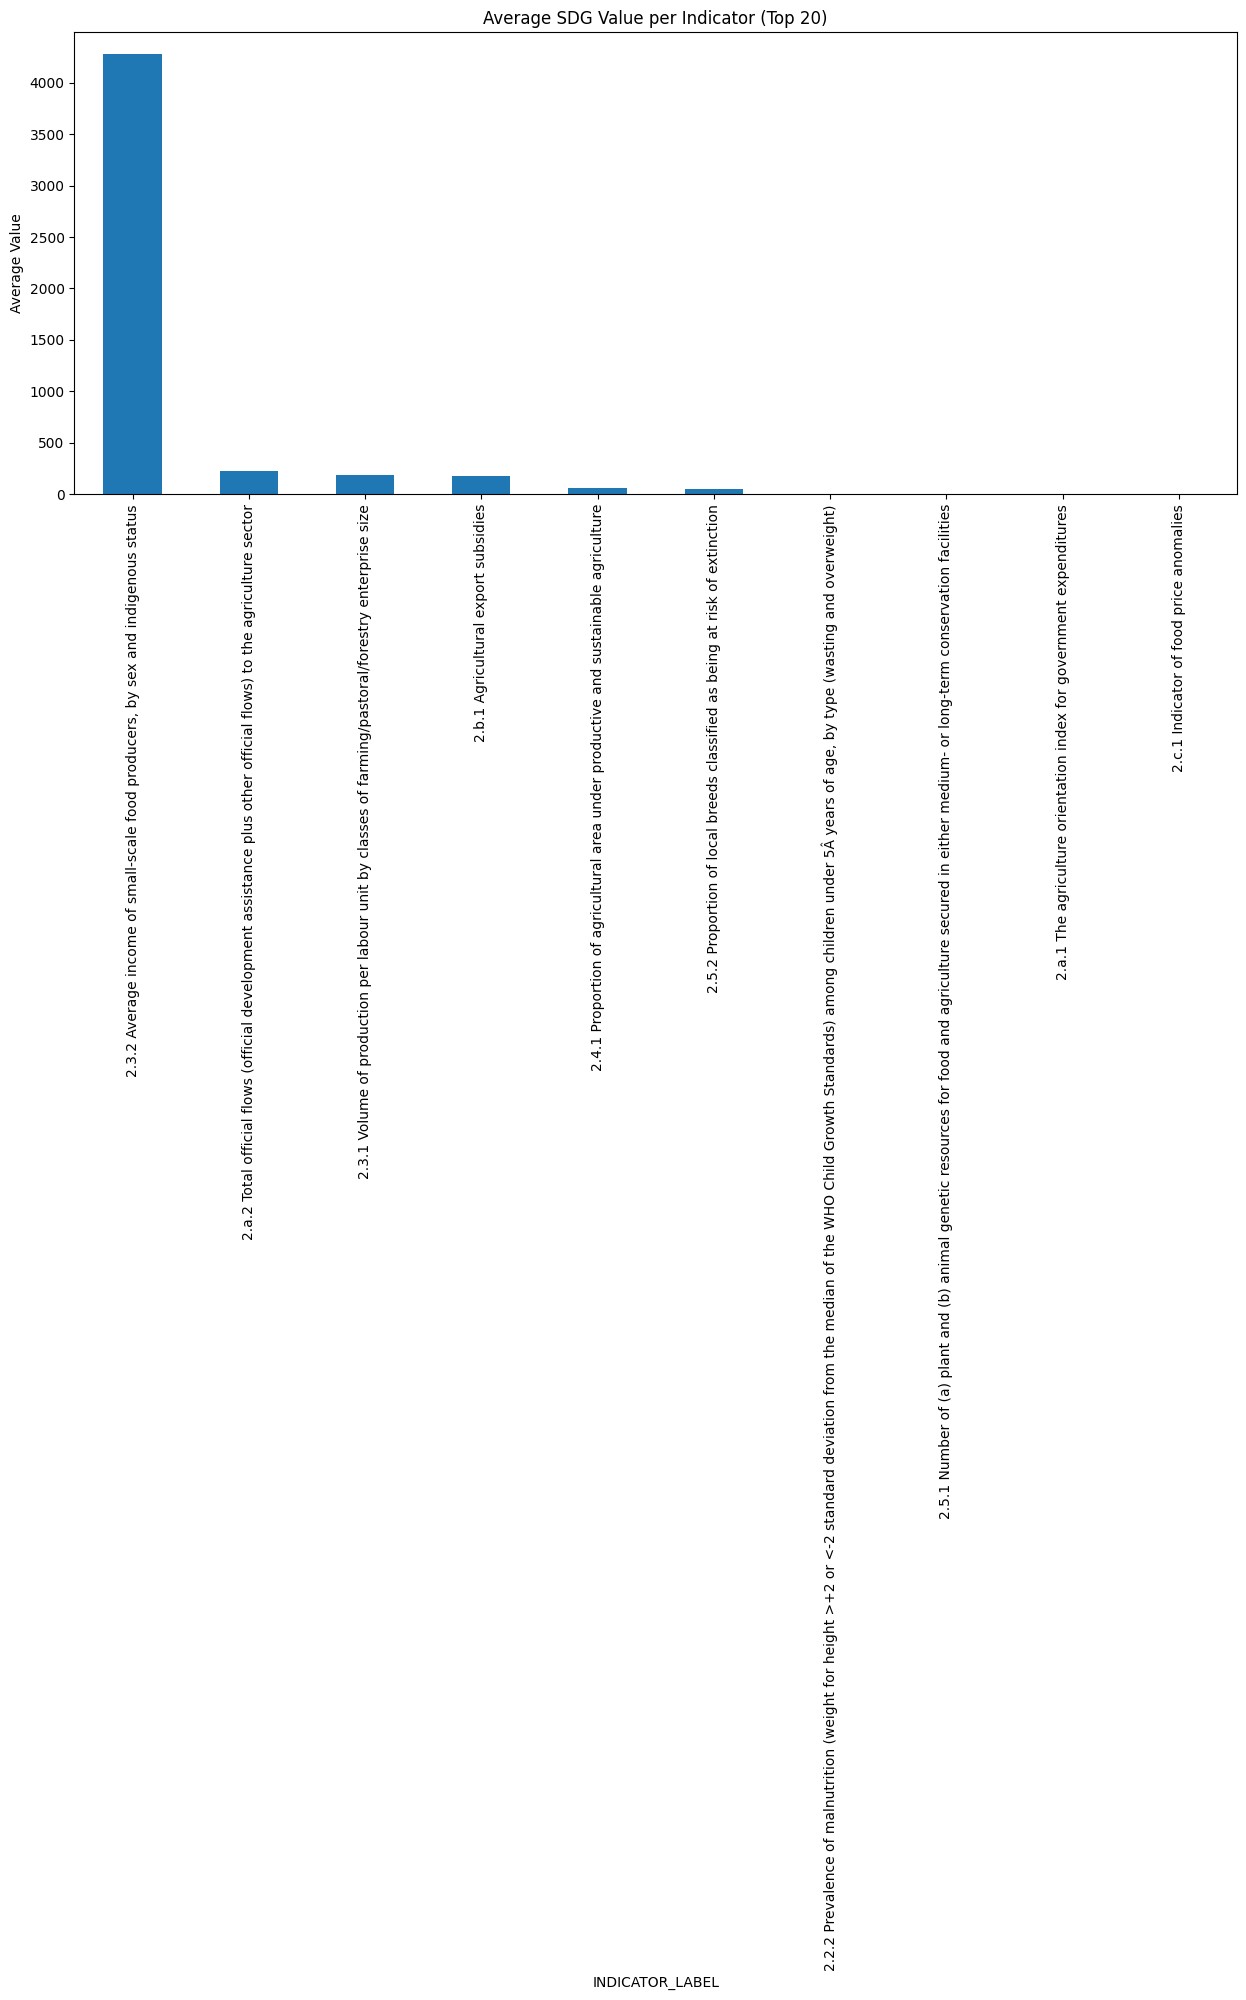

In [ ]:
# Average values per SDG indicator
avg_indicator = df.groupby('INDICATOR_LABEL')['OBS_VALUE'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
avg_indicator.head(20).plot(kind='bar')  # Top 20 indicators for readability
plt.title("Average SDG Value per Indicator (Top 20)")
plt.ylabel("Average Value")
plt.xticks(rotation=90)
plt.show()


/tmp/ipython-input-2790945483.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  d = d.groupby(["INDICATOR_LABEL", "TIME_PERIOD"], group_keys=False).apply(winsorize_iqr)


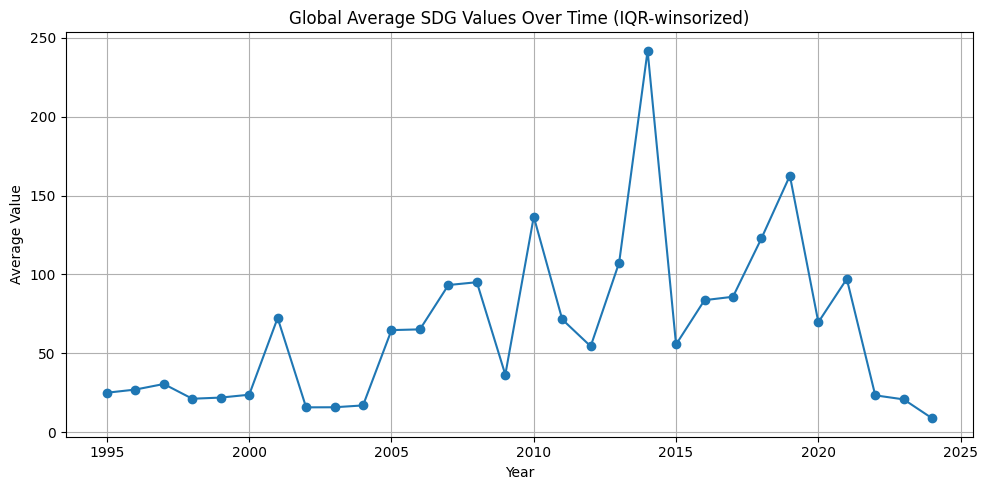

In [ ]:
# Global trend of SDG values over time — OUTLIER-ROBUST (IQR winsorized per INDICATOR × YEAR)

import pandas as pd
import matplotlib.pyplot as plt

# 1) Prep
d = df_clean.copy() if "df_clean" in globals() else df.copy()
d["OBS_VALUE"]   = pd.to_numeric(d["OBS_VALUE"], errors="coerce")
d["TIME_PERIOD"] = pd.to_numeric(d["TIME_PERIOD"], errors="coerce")
d = d.dropna(subset=["OBS_VALUE", "TIME_PERIOD", "INDICATOR_LABEL"])

# 2) Winsorize within each (INDICATOR, YEAR) to neutralize extreme country values
def winsorize_iqr(g, k=1.5):
    s = g["OBS_VALUE"]
    q1, q3 = s.quantile([0.25, 0.75]); iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    g["OBS_CLEAN"] = s.clip(lo, hi)
    return g

d = d.groupby(["INDICATOR_LABEL", "TIME_PERIOD"], group_keys=False).apply(winsorize_iqr)

# Optional: hard-clip percentage indicators to [0, 100]
mask_pct = d["INDICATOR_LABEL"].str.contains("%", na=False)
d.loc[mask_pct, "OBS_CLEAN"] = d.loc[mask_pct, "OBS_CLEAN"].clip(0, 100)

# 3) Aggregate globally by year and plot
avg_time = d.groupby("TIME_PERIOD")["OBS_CLEAN"].mean().sort_index()

plt.figure(figsize=(10, 5))
avg_time.plot(marker="o")
plt.title("Global Average SDG Values Over Time (IQR-winsorized)")
plt.xlabel("Year")
plt.ylabel("Average Value")
plt.grid(True)
plt.tight_layout()
plt.show()


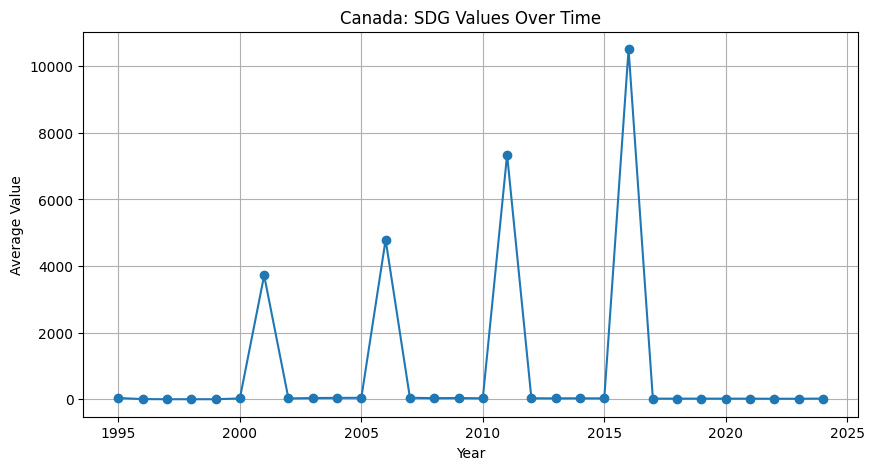

In [ ]:
#  Canada SDG value trends over time
Canada_data = df[df['REF_AREA_LABEL'] == 'Canada'].groupby('TIME_PERIOD')['OBS_VALUE'].mean()

plt.figure(figsize=(10, 5))
Canada_data.plot(marker='o')
plt.title("Canada: SDG Values Over Time")
plt.xlabel("Year")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()


Top 10 Countries by Average SDG Score:
                         Country  Average SDG Score
0                         Canada        2298.823021
1                 European Union        1703.523166
2                           Peru        1293.067497
3                         Africa        1079.887698
4                           Asia        1069.184164
5  Southern Asia (SDG aggregate)         932.356888
6                        Armenia         824.897007
7                       Mongolia         741.974580
8               Marshall Islands         724.648292
9                        Georgia         699.970566


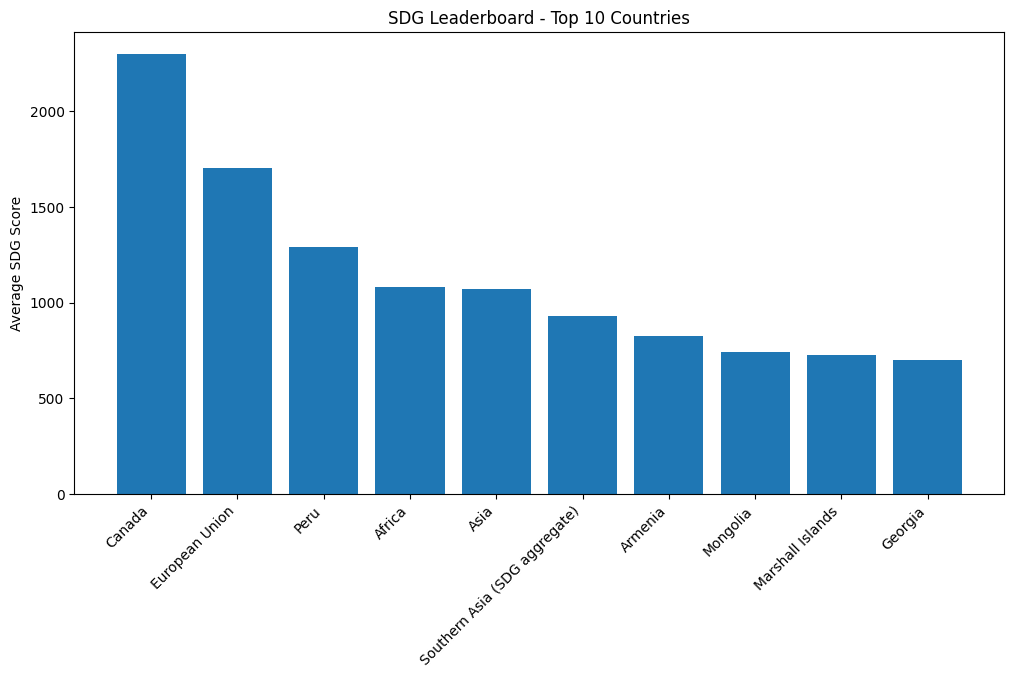

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate average score per country
leaderboard = df.groupby('REF_AREA_LABEL')['OBS_VALUE'].mean().sort_values(ascending=False)

# Convert to DataFrame for display
leaderboard_df = leaderboard.reset_index()
leaderboard_df.columns = ['Country', 'Average SDG Score']

# Show top 10
print("Top 10 Countries by Average SDG Score:")
print(leaderboard_df.head(10))

# Bar chart for top 10
plt.figure(figsize=(12, 6))
plt.bar(leaderboard_df['Country'].head(10), leaderboard_df['Average SDG Score'].head(10))
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average SDG Score")
plt.title("SDG Leaderboard - Top 10 Countries")
plt.show()


In [ ]:
# # Choose indicator
# target_indicator = "Proportion of population using safely managed drinking water services (%)"

# indicator_df = df[df['INDICATOR_LABEL'] == target_indicator]
# leaderboard_indicator = indicator_df.groupby('REF_AREA_LABEL')['OBS_VALUE'].mean().sort_values(ascending=False)

# # Display top 10
# print(f"Top 10 Countries for: {target_indicator}")
# # print(leaderboard_indicator.head(10))


In [ ]:
# # Filter for a specific year
# year_filter = 2020
# leaderboard_year = df[df['TIME_PERIOD'] == year_filter].groupby('REF_AREA_LABEL')['OBS_VALUE'].mean().sort_values(ascending=False)

# print(f"Top 10 Countries in {year_filter}")
# print(leaderboard_year.head(10))


In [ ]:
# import plotly.express as px

# # Get list of all SDG indicators in the dataset
# sdg_list = sorted(df['INDICATOR_LABEL'].unique())
# print("Available SDGs / Indicators:")
# for i, sdg in enumerate(sdg_list):
#     print(f"{i}: {sdg}")

# # Function to create leaderboard for a selected SDG
# def create_leaderboard(selected_sdg, speed=1500, top_n=10):
#     """
#     selected_sdg : string - the SDG indicator name
#     speed : int - milliseconds per frame (higher = slower animation)
#     top_n : int - number of countries to display in leaderboard
#     """
#     # Filter for the selected indicator
#     df_sdg = df[df["INDICATOR_LABEL"] == selected_sdg].copy()

#     # Group & rank by year and country
#     ranking_df = (
#         df_sdg.groupby(["TIME_PERIOD", "REF_AREA_LABEL"])["OBS_VALUE"]
#         .mean()
#         .reset_index()
#     )
#     ranking_df["Rank"] = ranking_df.groupby("TIME_PERIOD")["OBS_VALUE"] \
#                                    .rank(ascending=False, method="first")

#     # Keep only top N
#     top_df = ranking_df[ranking_df["Rank"] <= top_n]

#     # Create animated leaderboard
#     fig = px.bar(
#         top_df,
#         x="OBS_VALUE",
#         y="REF_AREA_LABEL",
#         color="REF_AREA_LABEL",
#         animation_frame="TIME_PERIOD",
#         orientation="h",
#         title=f"Leaderboard for: {selected_sdg}",
#         range_x=[0, top_df["OBS_VALUE"].max() * 1.1],
#         labels={"OBS_VALUE": "Value", "REF_AREA_LABEL": "Country/Region"}
#     )
#     fig.update_layout(
#         yaxis={'categoryorder': 'total ascending'},
#         updatemenus=[{
#             "buttons": [
#                 {
#                     "args": [None, {"frame": {"duration": speed, "redraw": True}, "fromcurrent": True}],
#                     "label": "Play",
#                     "method": "animate"
#                 },
#                 {
#                     "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
#                     "label": "Pause",
#                     "method": "animate"
#                 }
#             ],
#             "direction": "left",
#             "pad": {"r": 10, "t": 87},
#             "showactive": False,
#             "type": "buttons",
#             "x": 0.1,
#             "xanchor": "right",
#             "y": 0,
#             "yanchor": "top"
#         }]
#     )
#     fig.show()

# # Example usage:
# # Choose from printed list above
# selected_index = 5  # Change to your desired SDG index
# create_leaderboard(sdg_list[selected_index], speed=1200, top_n=10)


In [ ]:
!pip install pycountry pycountry-convert


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.8/248.8 kB 21.3 MB/s eta 0:00:00


In [ ]:
import pycountry_convert as pc



def get_region(country_name):
    try:
        # Convert country name to alpha-2 code
        country_code = pc.country_name_to_country_alpha2(country_name)
        # Convert to continent code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        # Map to readable region
        return {
            'AF': 'Africa',
            'EU': 'Europe',
            'AS': 'Asia',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania'
        }.get(continent_code, None)
    except:
        return None

# Apply region mapping
df["REGION_GROUP"] = df["REF_AREA_LABEL"].apply(get_region)

# Check what regions were mapped
print(df["REGION_GROUP"].value_counts())


REGION_GROUP
Africa           14053
Europe            9651
Asia              9137
North America     4782
South America     2970
Oceania           2586
Name: count, dtype: int64


In [ ]:
# ---------------- Region Leaderboards (slower + Play/Pause under slider) ----------------
import pandas as pd
import plotly.express as px
# assumes: df already loaded, and `import pycountry_convert as pc` done earlier

# Automatically map countries to region
def get_region(country_name):
    try:
        code = pc.country_name_to_country_alpha2(country_name)
        cont = pc.country_alpha2_to_continent_code(code)
        return {'AF':'Africa','EU':'Europe','AS':'Asia','NA':'North America','SA':'South America','OC':'Oceania'}.get(cont, None)
    except:
        return None

df["REGION_GROUP"] = df["REF_AREA_LABEL"].apply(get_region)

# Select the SDG Indicator (choose from list)
sdg_list = sorted(df["INDICATOR_LABEL"].unique())
print("Available SDG Indicators:")
for i, goal in enumerate(sdg_list):
    print(f"{i}: {goal}")

# Pick one SDG
selected_sdg = sdg_list[5]  # <- change index as needed

# Function to create regional animated leaderboard (with slower speed + bottom controls)
def create_region_leaderboard(selected_sdg, selected_region, top_n=10, speed=1800):
    region_df = df[(df["INDICATOR_LABEL"] == selected_sdg) & (df["REGION_GROUP"] == selected_region)]

    ranked = (region_df.groupby(["TIME_PERIOD","REF_AREA_LABEL"])["OBS_VALUE"].mean().reset_index())
    ranked["Rank"] = ranked.groupby("TIME_PERIOD")["OBS_VALUE"].rank(ascending=False, method="first")
    top_df = ranked[ranked["Rank"] <= top_n]

    if top_df.empty:
        print(f"[{selected_region}] No data for: {selected_sdg}")
        return

    xmax = top_df["OBS_VALUE"].max()
    xmax = 1.0 if pd.isna(xmax) or xmax <= 0 else float(xmax)

    fig = px.bar(
        top_df,
        x="OBS_VALUE",
        y="REF_AREA_LABEL",
        color="REF_AREA_LABEL",
        animation_frame="TIME_PERIOD",
        orientation="h",
        title=f"Top {top_n} Countries in {selected_region} – {selected_sdg}",
        range_x=[0, xmax * 1.1],
        labels={"OBS_VALUE": "Value", "REF_AREA_LABEL": "Country"}
    )

    # Put Play/Pause below near the year slider; slow the animation
    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        margin=dict(l=80, r=40, t=70, b=150),
        updatemenus=[{
            "type": "buttons",
            "showactive": False,
            "x": 0.5, "y": -0.18, "xanchor": "center", "yanchor": "top",
            "buttons": [
                {"label": "Play", "method": "animate",
                 "args": [None, {
                     "frame": {"duration": int(speed), "redraw": True},
                     "fromcurrent": True,
                     "transition": {"duration": int(speed/2)}
                 }]},
                {"label": "Pause", "method": "animate",
                 "args": [[None], {
                     "frame": {"duration": 0, "redraw": False},
                     "mode": "immediate",
                     "transition": {"duration": 0}
                 }]}
            ]
        }]
    )

    # Slow the slider steps too
    if hasattr(fig.layout, "sliders") and fig.layout.sliders:
        for s in fig.layout.sliders:
            s.pad.t = 30
            s.transition.duration = int(speed/2)
            for step in s.steps:
                if len(step.args) > 1 and isinstance(step.args[1], dict):
                    step.args[1].setdefault("frame", {})["duration"] = int(speed)

    fig.show()

# Generate for all 6 global regions
regions = ["Africa", "Europe", "Asia", "North America", "South America", "Oceania"]
for region in regions:
    print(f"\n⏳ Generating leaderboard for {region}...")
    create_region_leaderboard(selected_sdg, region, top_n=10, speed=5000)  # raise speed for slower


Available SDG Indicators:
0: 2.2.2 Prevalence of malnutrition (weight for height >+2 or <-2 standard deviation from the median of the WHO Child Growth Standards) among children under 5Â years of age, by type (wasting and overweight)
1: 2.3.1 Volume of production per labour unit by classes of farming/pastoral/forestry enterprise size
2: 2.3.2 Average income of small-scale food producers, by sex and indigenous status
3: 2.4.1 Proportion of agricultural area under productive and sustainable agriculture
4: 2.5.1 Number of (a) plant and (b) animal genetic resources for food and agriculture secured in either medium- or long-term conservation facilities
5: 2.5.2 Proportion of local breeds classified as being at risk of extinction
6: 2.a.1 The agriculture orientation index for government expenditures
7: 2.a.2 Total official flows (official development assistance plus other official flows) to the agriculture sector
8: 2.b.1 Agricultural export subsidies
9: 2.c.1 Indicator of food price anomalie


⏳ Generating leaderboard for Europe...



⏳ Generating leaderboard for Asia...



⏳ Generating leaderboard for North America...



⏳ Generating leaderboard for South America...



⏳ Generating leaderboard for Oceania...


In [ ]:
import sklearn; print(sklearn.__version__)


1.6.1



📍 Available Regions:
1. North America
2. Europe
3. Asia
4. Africa
5. South America
6. Oceania

Select region number: 4

📊 Available SDGs for Africa:
1. 2.2.2 Prevalence of malnutrition (weight for height >+2 or <-2 standard deviation from the median of the WHO Child Growth Standards) among children under 5Â years of age, by type (wasting and overweight)
2. 2.3.1 Volume of production per labour unit by classes of farming/pastoral/forestry enterprise size
3. 2.3.2 Average income of small-scale food producers, by sex and indigenous status
4. 2.5.1 Number of (a) plant and (b) animal genetic resources for food and agriculture secured in either medium- or long-term conservation facilities
5. 2.5.2 Proportion of local breeds classified as being at risk of extinction
6. 2.a.1 The agriculture orientation index for government expenditures
7. 2.a.2 Total official flows (official development assistance plus other official flows) to the agriculture sector
8. 2.b.1 Agricultural export subsidies
9. 

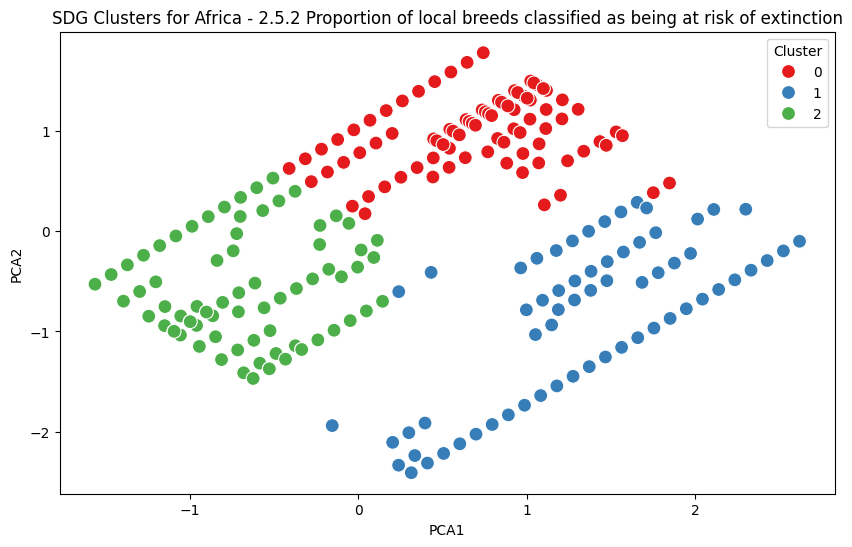


📊 Country Ranking by SDG Value:
      Country  SDG_Value  Cluster
     Tanzania      100.0        1
      Algeria      100.0        1
      Algeria      100.0        1
     Tanzania      100.0        1
     Tanzania      100.0        1
     Tanzania      100.0        1
      Algeria      100.0        1
      Algeria      100.0        1
      Lesotho      100.0        1
      Lesotho      100.0        1
      Lesotho      100.0        1
      Lesotho      100.0        1
     Eswatini      100.0        1
     Eswatini      100.0        1
     Eswatini      100.0        1
     Eswatini      100.0        1
     Eswatini      100.0        1
     Eswatini      100.0        1
     Eswatini      100.0        1
     Eswatini      100.0        1
     Eswatini      100.0        1
     Eswatini      100.0        1
      Lesotho      100.0        1
      Lesotho      100.0        1
      Lesotho      100.0        1
      Lesotho      100.0        1
      Lesotho      100.0        1
      Lesotho  

In [ ]:
# ======================================
# 1. Install and import dependencies
# ======================================
!pip install pycountry-convert joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import joblib

# ======================================
# 2. Load dataset
# ======================================
file_path = "/content/drive/MyDrive/DATA SETS/UN_SDG.csv"  # Change path if needed
df = pd.read_csv(file_path)

# ======================================
# 3. Map countries to regions
# ======================================
def get_region(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        return {
            'AF': 'Africa',
            'EU': 'Europe',
            'AS': 'Asia',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania'
        }.get(continent_code, None)
    except:
        return None

df["REGION_GROUP"] = df["REF_AREA_LABEL"].apply(get_region)
# ======================================
# 4. Dynamic selection of Region & SDG
# ======================================
available_regions = df["REGION_GROUP"].dropna().unique().tolist()
print("\n📍 Available Regions:")
for i, reg in enumerate(available_regions, start=1):
    print(f"{i}. {reg}")

region_index = int(input("\nSelect region number: ")) - 1
region_choice = available_regions[region_index]

# Show available SDGs for the selected region
available_sdgs = sorted(df[df["REGION_GROUP"] == region_choice]["INDICATOR_LABEL"].unique())
print(f"\n📊 Available SDGs for {region_choice}:")
for i, sdg in enumerate(available_sdgs, start=1):
    print(f"{i}. {sdg}")

sdg_index = int(input("\nSelect SDG number: ")) - 1
sdg_choice = available_sdgs[sdg_index]


# ======================================
# 5. Filter Data
# ======================================
filtered_df = df[
    (df["REGION_GROUP"] == region_choice) &
    (df["INDICATOR_LABEL"] == sdg_choice)
]

if filtered_df.empty:
    raise ValueError(f"No data found for region '{region_choice}' and SDG '{sdg_choice}'")

# ======================================
# 6. Data preprocessing
# ======================================
numeric_cols = filtered_df.select_dtypes(include=[np.number]).columns.tolist()
filtered_df = filtered_df.dropna(subset=numeric_cols)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(filtered_df[numeric_cols])

# ======================================
# 7. PCA (only if >1 feature)
# ======================================
if data_scaled.shape[1] > 1:
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data_scaled)
else:
    pca_data = np.column_stack((data_scaled[:, 0], np.zeros(len(data_scaled))))

numeric_df = pd.DataFrame({
    "PCA1": pca_data[:, 0],
    "PCA2": pca_data[:, 1],
    "Country": filtered_df["REF_AREA_LABEL"].values,
    "SDG_Value": filtered_df["OBS_VALUE"].values
})

# ======================================
# 8. K-Means Clustering
# ======================================
kmeans = KMeans(n_clusters=3, random_state=42)
numeric_df["Cluster"] = kmeans.fit_predict(numeric_df[["PCA1", "PCA2"]])

# ======================================
# 9. Save Model & Scaler
# ======================================
joblib.dump(kmeans, "sdg_kmeans_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("✅ Model and scaler saved as 'sdg_kmeans_model.pkl' and 'scaler.pkl'")

# ======================================
# 10. Plot Clusters WITHOUT labels
# ======================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=numeric_df,
    x="PCA1", y="PCA2",
    hue="Cluster", palette="Set1", s=100
)
plt.title(f"SDG Clusters for {region_choice} - {sdg_choice}")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()

# ======================================
# 11. Ranking Countries by SDG Value
# ======================================
ranking = numeric_df[["Country", "SDG_Value", "Cluster"]].sort_values(by="SDG_Value", ascending=False)
print("\n📊 Country Ranking by SDG Value:")
print(ranking.to_string(index=False))

In [ ]:
# # SDG Analytics Dashboard with Gradio

# import gradio as gr
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import plotly.express as px
# import plotly.graph_objects as go
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# import warnings
# warnings.filterwarnings('ignore')

# #styling
# plt.style.use('default')
# sns.set_palette("husl")

# # Global variables to store data
# df = None
# df_clean = None

# def load_data(file):
#     """Load and preprocess the SDG data"""
#     global df, df_clean

#     try:
#         # Fixed: Use file path directly since type="filepath"
#         df = pd.read_csv(file)

#         # Basic preprocessing
#         df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
#         df['TIME_PERIOD'] = pd.to_numeric(df['TIME_PERIOD'], errors='coerce')

#         # Clean outliers using IQR method
#         df_clean = clean_outliers(df)

#         # Add region mapping
#         df['REGION_GROUP'] = df['REF_AREA_LABEL'].apply(get_region)
#         df_clean['REGION_GROUP'] = df_clean['REF_AREA_LABEL'].apply(get_region)

#         info = f"""
#         📊 **Dataset Loaded Successfully!**

#         - **Shape**: {df.shape[0]:,} rows × {df.shape[1]} columns
#         - **Countries**: {df['REF_AREA_LABEL'].nunique()}
#         - **SDG Indicators**: {df['INDICATOR_LABEL'].nunique()}
#         - **Time Period**: {df['TIME_PERIOD'].min():.0f} - {df['TIME_PERIOD'].max():.0f}
#         - **Regions Mapped**: {df['REGION_GROUP'].nunique()} regions
#         """

#         return info, get_available_indicators(), get_available_countries(), get_available_regions()

#     except Exception as e:
#         return f"❌ Error loading data: {str(e)}", [], [], []

# def get_region(country_name):
#     """Map country to region - Enhanced mapping"""
#     region_mapping = {
#         # Africa
#         'Algeria': 'Africa', 'Angola': 'Africa', 'Benin': 'Africa', 'Botswana': 'Africa',
#         'Burkina Faso': 'Africa', 'Burundi': 'Africa', 'Cameroon': 'Africa', 'Cape Verde': 'Africa',
#         'Central African Republic': 'Africa', 'Chad': 'Africa', 'Comoros': 'Africa', 'Congo': 'Africa',
#         'Democratic Republic of the Congo': 'Africa', 'Djibouti': 'Africa', 'Egypt': 'Africa',
#         'Equatorial Guinea': 'Africa', 'Eritrea': 'Africa', 'Ethiopia': 'Africa', 'Gabon': 'Africa',
#         'Gambia': 'Africa', 'Ghana': 'Africa', 'Guinea': 'Africa', 'Guinea-Bissau': 'Africa',
#         'Kenya': 'Africa', 'Lesotho': 'Africa', 'Liberia': 'Africa', 'Libya': 'Africa',
#         'Madagascar': 'Africa', 'Malawi': 'Africa', 'Mali': 'Africa', 'Mauritania': 'Africa',
#         'Mauritius': 'Africa', 'Morocco': 'Africa', 'Mozambique': 'Africa', 'Namibia': 'Africa',
#         'Niger': 'Africa', 'Nigeria': 'Africa', 'Rwanda': 'Africa', 'Sao Tome and Principe': 'Africa',
#         'Senegal': 'Africa', 'Seychelles': 'Africa', 'Sierra Leone': 'Africa', 'Somalia': 'Africa',
#         'South Africa': 'Africa', 'South Sudan': 'Africa', 'Sudan': 'Africa', 'Swaziland': 'Africa',
#         'Tanzania': 'Africa', 'Togo': 'Africa', 'Tunisia': 'Africa', 'Uganda': 'Africa',
#         'Zambia': 'Africa', 'Zimbabwe': 'Africa',

#         # Asia
#         'Afghanistan': 'Asia', 'Bangladesh': 'Asia', 'Bhutan': 'Asia', 'Brunei': 'Asia',
#         'Cambodia': 'Asia', 'China': 'Asia', 'India': 'Asia', 'Indonesia': 'Asia',
#         'Japan': 'Asia', 'Kazakhstan': 'Asia', 'Kyrgyzstan': 'Asia', 'Laos': 'Asia',
#         'Malaysia': 'Asia', 'Maldives': 'Asia', 'Mongolia': 'Asia', 'Myanmar': 'Asia',
#         'Nepal': 'Asia', 'North Korea': 'Asia', 'Pakistan': 'Asia', 'Philippines': 'Asia',
#         'Singapore': 'Asia', 'South Korea': 'Asia', 'Sri Lanka': 'Asia', 'Tajikistan': 'Asia',
#         'Thailand': 'Asia', 'Timor-Leste': 'Asia', 'Turkmenistan': 'Asia', 'Uzbekistan': 'Asia',
#         'Vietnam': 'Asia', 'Armenia': 'Asia', 'Azerbaijan': 'Asia', 'Bahrain': 'Asia',
#         'Cyprus': 'Asia', 'Georgia': 'Asia', 'Iran': 'Asia', 'Iraq': 'Asia',
#         'Israel': 'Asia', 'Jordan': 'Asia', 'Kuwait': 'Asia', 'Lebanon': 'Asia',
#         'Oman': 'Asia', 'Qatar': 'Asia', 'Saudi Arabia': 'Asia', 'Syria': 'Asia',
#         'Turkey': 'Asia', 'United Arab Emirates': 'Asia', 'Yemen': 'Asia',

#         # Europe
#         'Albania': 'Europe', 'Austria': 'Europe', 'Belarus': 'Europe', 'Belgium': 'Europe',
#         'Bosnia and Herzegovina': 'Europe', 'Bulgaria': 'Europe', 'Croatia': 'Europe',
#         'Czech Republic': 'Europe', 'Denmark': 'Europe', 'Estonia': 'Europe', 'Finland': 'Europe',
#         'France': 'Europe', 'Germany': 'Europe', 'Greece': 'Europe', 'Hungary': 'Europe',
#         'Iceland': 'Europe', 'Ireland': 'Europe', 'Italy': 'Europe', 'Latvia': 'Europe',
#         'Lithuania': 'Europe', 'Luxembourg': 'Europe', 'Malta': 'Europe', 'Moldova': 'Europe',
#         'Montenegro': 'Europe', 'Netherlands': 'Europe', 'North Macedonia': 'Europe',
#         'Norway': 'Europe', 'Poland': 'Europe', 'Portugal': 'Europe', 'Romania': 'Europe',
#         'Russia': 'Europe', 'Serbia': 'Europe', 'Slovakia': 'Europe', 'Slovenia': 'Europe',
#         'Spain': 'Europe', 'Sweden': 'Europe', 'Switzerland': 'Europe', 'Ukraine': 'Europe',
#         'United Kingdom': 'Europe',

#         # North America
#         'Canada': 'North America', 'Mexico': 'North America', 'United States': 'North America',
#         'Antigua and Barbuda': 'North America', 'Bahamas': 'North America', 'Barbados': 'North America',
#         'Belize': 'North America', 'Costa Rica': 'North America', 'Cuba': 'North America',
#         'Dominica': 'North America', 'Dominican Republic': 'North America', 'El Salvador': 'North America',
#         'Grenada': 'North America', 'Guatemala': 'North America', 'Haiti': 'North America',
#         'Honduras': 'North America', 'Jamaica': 'North America', 'Nicaragua': 'North America',
#         'Panama': 'North America', 'Saint Kitts and Nevis': 'North America',
#         'Saint Lucia': 'North America', 'Saint Vincent and the Grenadines': 'North America',
#         'Trinidad and Tobago': 'North America',

#         # South America
#         'Argentina': 'South America', 'Bolivia': 'South America', 'Brazil': 'South America',
#         'Chile': 'South America', 'Colombia': 'South America', 'Ecuador': 'South America',
#         'Guyana': 'South America', 'Paraguay': 'South America', 'Peru': 'South America',
#         'Suriname': 'South America', 'Uruguay': 'South America', 'Venezuela': 'South America',

#         # Oceania
#         'Australia': 'Oceania', 'Fiji': 'Oceania', 'Kiribati': 'Oceania', 'Marshall Islands': 'Oceania',
#         'Micronesia': 'Oceania', 'Nauru': 'Oceania', 'New Zealand': 'Oceania', 'Palau': 'Oceania',
#         'Papua New Guinea': 'Oceania', 'Samoa': 'Oceania', 'Solomon Islands': 'Oceania',
#         'Tonga': 'Oceania', 'Tuvalu': 'Oceania', 'Vanuatu': 'Oceania'
#     }
#     return region_mapping.get(country_name, 'Other')

# def clean_outliers(data):
#     """Clean outliers using IQR method"""
#     df_clean = data.copy()

#     for indicator in df_clean['INDICATOR_LABEL'].unique():
#         mask = df_clean['INDICATOR_LABEL'] == indicator
#         values = df_clean.loc[mask, 'OBS_VALUE']

#         if len(values) > 0:
#             Q1 = values.quantile(0.25)
#             Q3 = values.quantile(0.75)
#             IQR = Q3 - Q1

#             if IQR > 0:
#                 lower_bound = Q1 - 1.5 * IQR
#                 upper_bound = Q3 + 1.5 * IQR

#                 # Winsorize (clip) outliers
#                 df_clean.loc[mask, 'OBS_VALUE'] = values.clip(lower_bound, upper_bound)

#     return df_clean

# def get_available_indicators():
#     """Get list of available SDG indicators"""
#     if df is not None:
#         return sorted(df['INDICATOR_LABEL'].unique().tolist())
#     return []

# def get_available_countries():
#     """Get list of available countries"""
#     if df is not None:
#         return sorted(df['REF_AREA_LABEL'].unique().tolist())
#     return []

# def get_available_regions():
#     """Get list of available regions"""
#     if df is not None:
#         return sorted(df['REGION_GROUP'].dropna().unique().tolist())
#     return []

# def create_global_trend_plot():
#     """Create global trend visualization"""
#     if df_clean is None:
#         return None

#     # Calculate global average by year
#     global_trend = df_clean.groupby('TIME_PERIOD')['OBS_VALUE'].mean().reset_index()

#     fig = go.Figure()
#     fig.add_trace(go.Scatter(
#         x=global_trend['TIME_PERIOD'],
#         y=global_trend['OBS_VALUE'],
#         mode='lines+markers',
#         name='Global Average',
#         line=dict(color='#E91E63', width=3),
#         marker=dict(size=8, color='#E91E63')
#     ))

#     fig.update_layout(
#         title='🌍 Global SDG Progress Over Time',
#         xaxis_title='Year',
#         yaxis_title='Average SDG Value',
#         template='plotly_white',
#         font=dict(family="Roboto, sans-serif"),
#         title_font=dict(size=20, color='#E91E63'),
#         height=500,
#         showlegend=False
#     )

#     return fig

# def create_country_leaderboard():
#     """Create country leaderboard"""
#     if df is None:
#         return None

#     leaderboard = df.groupby('REF_AREA_LABEL')['OBS_VALUE'].mean().sort_values(ascending=False).head(15)

#     fig = go.Figure(data=[
#         go.Bar(
#             x=leaderboard.values,
#             y=leaderboard.index,
#             orientation='h',
#             marker_color='#E91E63',
#             text=[f'{val:.1f}' for val in leaderboard.values],
#             textposition='auto',
#         )
#     ])

#     fig.update_layout(
#         title='🏆 Top 15 Countries by Average SDG Score',
#         xaxis_title='Average SDG Score',
#         yaxis_title='Country',
#         template='plotly_white',
#         font=dict(family="Roboto, sans-serif"),
#         title_font=dict(size=18, color='#E91E63'),
#         height=600
#     )

#     return fig

# def create_indicator_analysis(indicator):
#     """Analyze specific SDG indicator"""
#     if df is None or not indicator:
#         return None, "Please select an indicator"

#     indicator_data = df[df['INDICATOR_LABEL'] == indicator]

#     if indicator_data.empty:
#         return None, "No data found for selected indicator"

#     # Top 10 countries for this indicator
#     top_countries = indicator_data.groupby('REF_AREA_LABEL')['OBS_VALUE'].mean().sort_values(ascending=False).head(10)

#     fig = go.Figure(data=[
#         go.Bar(
#             x=top_countries.index,
#             y=top_countries.values,
#             marker_color='#E91E63',
#             text=[f'{val:.1f}' for val in top_countries.values],
#             textposition='auto',
#         )
#     ])

#     fig.update_layout(
#         title=f'📊 Top 10 Countries: {indicator[:50]}...',
#         xaxis_title='Country',
#         yaxis_title='SDG Value',
#         template='plotly_white',
#         font=dict(family="Roboto, sans-serif"),
#         title_font=dict(size=16, color='#E91E63'),
#         height=500,
#         xaxis_tickangle=-45
#     )

#     stats = f"""
#     📈 **Indicator Analysis: {indicator[:60]}...**

#     - **Average Value**: {indicator_data['OBS_VALUE'].mean():.2f}
#     - **Standard Deviation**: {indicator_data['OBS_VALUE'].std():.2f}
#     - **Countries with Data**: {indicator_data['REF_AREA_LABEL'].nunique()}
#     - **Time Range**: {indicator_data['TIME_PERIOD'].min():.0f} - {indicator_data['TIME_PERIOD'].max():.0f}
#     - **Best Performing**: {top_countries.index[0]} ({top_countries.iloc[0]:.2f})
#     - **Data Points**: {len(indicator_data):,}
#     """

#     return fig, stats

# def create_regional_comparison():
#     """Create regional comparison visualization"""
#     if df is None:
#         return None

#     regional_avg = df.groupby('REGION_GROUP')['OBS_VALUE'].mean().sort_values(ascending=False)

#     colors = ['#E91E63', '#F06292', '#F8BBD9', '#FCE4EC', '#E1F5FE', '#B3E5FC', '#81C784']

#     fig = go.Figure(data=[
#         go.Bar(
#             x=regional_avg.index,
#             y=regional_avg.values,
#             marker_color=colors[:len(regional_avg)],
#             text=[f'{val:.1f}' for val in regional_avg.values],
#             textposition='auto',
#         )
#     ])

#     fig.update_layout(
#         title='🗺️ Regional SDG Performance Comparison',
#         xaxis_title='Region',
#         yaxis_title='Average SDG Score',
#         template='plotly_white',
#         font=dict(family="Roboto, sans-serif"),
#         title_font=dict(size=18, color='#E91E63'),
#         height=500
#     )

#     return fig

# def create_clustering_analysis(region, indicator):
#     """Create clustering analysis for selected region and indicator"""
#     if df is None or not region or not indicator:
#         return None, "Please select region and indicator"

#     filtered_data = df[(df['REGION_GROUP'] == region) & (df['INDICATOR_LABEL'] == indicator)]

#     if len(filtered_data) < 5:
#         return None, "❌ Not enough data points for clustering analysis (minimum 5 required)"

#     # Prepare data for clustering
#     country_values = filtered_data.groupby('REF_AREA_LABEL')['OBS_VALUE'].mean().reset_index()

#     if len(country_values) < 3:
#         return None, "❌ Not enough countries for clustering (minimum 3 required)"

#     # Standardize the data
#     scaler = StandardScaler()
#     values_scaled = scaler.fit_transform(country_values[['OBS_VALUE']])

#     # Create 2D data for visualization (using value and rank)
#     country_values['Rank'] = country_values['OBS_VALUE'].rank(ascending=False)

#     # K-means clustering
#     n_clusters = min(3, len(country_values))
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     country_values['Cluster'] = kmeans.fit_predict(country_values[['OBS_VALUE', 'Rank']])

#     # Create scatter plot
#     colors = ['#E91E63', '#9C27B0', '#3F51B5', '#4CAF50', '#FF9800']
#     fig = go.Figure()

#     for cluster in sorted(country_values['Cluster'].unique()):
#         cluster_data = country_values[country_values['Cluster'] == cluster]
#         fig.add_trace(go.Scatter(
#             x=cluster_data['OBS_VALUE'],
#             y=cluster_data['Rank'],
#             mode='markers+text',
#             name=f'Cluster {cluster + 1}',
#             text=cluster_data['REF_AREA_LABEL'],
#             textposition='top center',
#             marker=dict(size=12, color=colors[cluster % len(colors)]),
#             textfont=dict(size=10)
#         ))

#     fig.update_layout(
#         title=f'🎯 Country Clustering: {region} - {indicator[:30]}...',
#         xaxis_title='SDG Value',
#         yaxis_title='Rank (1 = Best)',
#         template='plotly_white',
#         font=dict(family="Roboto, sans-serif"),
#         title_font=dict(size=16, color='#E91E63'),
#         height=600
#     )

#     # Generate summary
#     cluster_info = []
#     for cluster in sorted(country_values['Cluster'].unique()):
#         cluster_countries = country_values[country_values['Cluster'] == cluster]['REF_AREA_LABEL'].tolist()
#         avg_value = country_values[country_values['Cluster'] == cluster]['OBS_VALUE'].mean()
#         cluster_info.append(f"**Cluster {cluster + 1}**: {', '.join(cluster_countries)} (Avg: {avg_value:.2f})")

#     summary = f"""
#     🎯 **Clustering Analysis Results**

#     - **Region**: {region}
#     - **Indicator**: {indicator[:50]}...
#     - **Countries Analyzed**: {len(country_values)}
#     - **Clusters Identified**: {len(country_values['Cluster'].unique())}
#     - **Best Performer**: {country_values.loc[country_values['OBS_VALUE'].idxmax(), 'REF_AREA_LABEL']} ({country_values['OBS_VALUE'].max():.2f})
#     - **Average Score**: {country_values['OBS_VALUE'].mean():.2f}

#     **Cluster Details:**
#     {chr(10).join(cluster_info)}
#     """

#     return fig, summary

# def create_time_series_country(country):
#     """Create time series for specific country"""
#     if df is None or not country:
#         return None

#     country_data = df[df['REF_AREA_LABEL'] == country]

#     if country_data.empty:
#         return None

#     time_series = country_data.groupby('TIME_PERIOD')['OBS_VALUE'].mean().reset_index()

#     fig = go.Figure()
#     fig.add_trace(go.Scatter(
#         x=time_series['TIME_PERIOD'],
#         y=time_series['OBS_VALUE'],
#         mode='lines+markers',
#         name=country,
#         line=dict(color='#E91E63', width=3),
#         marker=dict(size=8, color='#E91E63'),
#         fill='tonexty',
#         fillcolor='rgba(233, 30, 99, 0.1)'
#     ))

#     # Add trend line
#     if len(time_series) > 1:
#         z = np.polyfit(time_series['TIME_PERIOD'], time_series['OBS_VALUE'], 1)
#         p = np.poly1d(z)
#         fig.add_trace(go.Scatter(
#             x=time_series['TIME_PERIOD'],
#             y=p(time_series['TIME_PERIOD']),
#             mode='lines',
#             name='Trend',
#             line=dict(color='#FF9800', width=2, dash='dash')
#         ))

#     fig.update_layout(
#         title=f'📈 SDG Progress Over Time: {country}',
#         xaxis_title='Year',
#         yaxis_title='Average SDG Value',
#         template='plotly_white',
#         font=dict(family="Roboto, sans-serif"),
#         title_font=dict(size=18, color='#E91E63'),
#         height=500
#     )

#     return fig

# # Custom CSS for pink theme and Roboto font
# custom_css = """
# @import url('https://fonts.googleapis.com/css2?family=Roboto:wght@300;400;500;700&display=swap');

# .gradio-container {
#     font-family: 'Roboto', sans-serif !important;
#     background: linear-gradient(135deg, #fce4ec 0%, #f8bbd9 100%) !important;
# }

# .gr-button-primary {
#     background: linear-gradient(45deg, #E91E63, #F06292) !important;
#     border: none !important;
#     font-family: 'Roboto', sans-serif !important;
#     font-weight: 500 !important;
#     border-radius: 10px !important;
#     transition: all 0.3s ease !important;
# }

# .gr-button-primary:hover {
#     background: linear-gradient(45deg, #C2185B, #E91E63) !important;
#     transform: translateY(-2px) !important;
#     box-shadow: 0 4px 12px rgba(233, 30, 99, 0.3) !important;
# }

# .gr-form {
#     background: rgba(255, 255, 255, 0.9) !important;
#     border-radius: 15px !important;
#     padding: 20px !important;
#     border: 1px solid #F8BBD9 !important;
#     backdrop-filter: blur(10px) !important;
# }

# .gr-panel {
#     border-radius: 15px !important;
#     border: 1px solid #F8BBD9 !important;
#     background: rgba(255, 255, 255, 0.95) !important;
# }

# h1 {
#     color: #E91E63 !important;
#     font-family: 'Roboto', sans-serif !important;
#     font-weight: 700 !important;
#     text-align: center !important;
#     margin-bottom: 20px !important;
# }

# h2, h3 {
#     color: #E91E63 !important;
#     font-family: 'Roboto', sans-serif !important;
#     font-weight: 500 !important;
# }

# .gr-markdown {
#     font-family: 'Roboto', sans-serif !important;
# }

# .gr-tab-nav {
#     border-bottom: 2px solid #F8BBD9 !important;
#     background: rgba(255, 255, 255, 0.9) !important;
#     border-radius: 10px 10px 0 0 !important;
# }

# .gr-tab-nav button {
#     font-family: 'Roboto', sans-serif !important;
#     font-weight: 500 !important;
#     color: #666 !important;
# }

# .gr-tab-nav button.selected {
#     border-bottom: 3px solid #E91E63 !important;
#     color: #E91E63 !important;
#     background: rgba(233, 30, 99, 0.1) !important;
# }

# .gr-file {
#     border: 2px dashed #F8BBD9 !important;
#     border-radius: 10px !important;
# }

# .gr-dropdown {
#     border-radius: 8px !important;
#     border: 1px solid #F8BBD9 !important;
# }

# .footer {
#     text-align: center !important;
#     color: #E91E63 !important;
#     font-family: 'Roboto', sans-serif !important;
#     margin-top: 20px !important;
# }
# """

# # Create Gradio interface
# with gr.Blocks(css=custom_css, title="SDG Analytics Dashboard", theme=gr.themes.Soft()) as app:

#     # Header
#     gr.HTML("""
#     <div style="text-align: center; padding: 20px;">
#         <h1 style="color: #E91E63; font-family: 'Roboto', sans-serif; font-size: 2.5em; margin-bottom: 10px;">
#             🌍 SDG Analytics Dashboard
#         </h1>
#         <p style="color: #666; font-size: 1.2em; font-family: 'Roboto', sans-serif;">
#             Comprehensive Analysis of Sustainable Development Goals Data
#         </p>
#         <p style="color: #888; font-family: 'Roboto', sans-serif;">
#             Upload your SDG dataset to explore global progress, country rankings, and regional comparisons
#         </p>
#     </div>
#     """)

#     # File upload section
#     with gr.Row():
#         with gr.Column(scale=2):
#             file_input = gr.File(
#                 label="📁 Upload SDG Dataset (CSV)",
#                 file_types=[".csv"],
#                 type="filepath",  # FIXED: Changed from "file" to "filepath"
#                 height=100
#             )

#         with gr.Column(scale=3):
#             data_info = gr.Markdown("Upload a CSV file to get started...")

#     # Hidden components to store data
#     indicators_state = gr.State([])
#     countries_state = gr.State([])
#     regions_state = gr.State([])

#     # Main content tabs
#     with gr.Tabs():

#         # Global Overview Tab
#         with gr.TabItem("🌎 Global Overview"):
#             gr.Markdown("### Global SDG Performance Analysis")

#             with gr.Row():
#                 with gr.Column():
#                     global_trend_plot = gr.Plot(label="Global SDG Trends Over Time")
#                 with gr.Column():
#                     country_leaderboard_plot = gr.Plot(label="Top Performing Countries")

#             regional_comparison_plot = gr.Plot(label="Regional Performance Comparison")

#         # Indicator Analysis Tab
#         with gr.TabItem("📊 Indicator Analysis"):
#             gr.Markdown("### Detailed SDG Indicator Analysis")

#             with gr.Row():
#                 indicator_dropdown = gr.Dropdown(
#                     label="🎯 Select SDG Indicator",
#                     choices=[],
#                     interactive=True,
#                     info="Choose a specific SDG indicator to analyze"
#                 )

#             with gr.Row():
#                 with gr.Column(scale=2):
#                     indicator_plot = gr.Plot(label="Top Countries for Selected Indicator")
#                 with gr.Column(scale=1):
#                     indicator_stats = gr.Markdown("Select an indicator to see detailed analysis...")

#         # Clustering Analysis Tab
#         with gr.TabItem("🔍 Clustering Analysis"):
#             gr.Markdown("### K-Means Clustering by Region and Indicator")

#             with gr.Row():
#                 region_dropdown = gr.Dropdown(
#                     label="🌍 Select Region",
#                     choices=[],
#                     interactive=True,
#                     info="Choose a region for clustering analysis"
#                 )
#                 cluster_indicator_dropdown = gr.Dropdown(
#                     label="📈 Select SDG Indicator",
#                     choices=[],
#                     interactive=True,
#                     info="Choose an indicator for clustering"
#                 )

#             with gr.Row():
#                 with gr.Column(scale=2):
#                     clustering_plot = gr.Plot(label="Country Clusters Visualization")
#                 with gr.Column(scale=1):
#                     clustering_summary = gr.Markdown("Select region and indicator for clustering analysis...")

#         # Country Trends Tab
#         with gr.TabItem("📈 Country Trends"):
#             gr.Markdown("### Individual Country Progress Analysis")

#             with gr.Row():
#                 country_dropdown = gr.Dropdown(
#                     label="🏳️ Select Country",
#                     choices=[],
#                     interactive=True,
#                     info="Choose a country to view its SDG progress over time"
#                 )

#             country_trend_plot = gr.Plot(label="Country SDG Progress Over Time")

#     # Footer
#     gr.HTML("""
#     <div class="footer" style="text-align: center; padding: 20px; margin-top: 30px; border-top: 1px solid #F8BBD9;">
#         <p style="color: #E91E63; font-family: 'Roboto', sans-serif;">
#             🌟 Built with Gradio | SDG Analytics Dashboard | Roboto Font & Pink Theme 🌟
#         </p>
#     </div>
#     """)

#     # ===== EVENT HANDLERS =====

#     # Main data loading function
#     def update_data_and_components(file):
#         if file is None:
#             return "Upload a CSV file to get started...", [], [], [], None, None, None

#         info, indicators, countries, regions = load_data(file)

#         # Create initial plots
#         global_plot = create_global_trend_plot()
#         leaderboard_plot = create_country_leaderboard()
#         regional_plot = create_regional_comparison()

#         return info, indicators, countries, regions, global_plot, leaderboard_plot, regional_plot

#     # File upload event
#     file_input.change(
#         fn=update_data_and_components,
#         inputs=[file_input],
#         outputs=[
#             data_info,
#             indicators_state,
#             countries_state,
#             regions_state,
#             global_trend_plot,
#             country_leaderboard_plot,
#             regional_comparison_plot
#         ]
#     )

#     # Update dropdowns when data changes
#     indicators_state.change(
#         lambda x: gr.update(choices=x),
#         inputs=[indicators_state],
#         outputs=[indicator_dropdown]
#     )

#     indicators_state.change(
#         lambda x: gr.update(choices=x),
#         inputs=[indicators_state],
#         outputs=[cluster_indicator_dropdown]
#     )

#     countries_state.change(
#         lambda x: gr.update(choices=x),
#         inputs=[countries_state],
#         outputs=[country_dropdown]
#     )

#     regions_state.change(
#         lambda x: gr.update(choices=x),
#         inputs=[regions_state],
#         outputs=[region_dropdown]
#     )

#     # Indicator analysis events
#     indicator_dropdown.change(
#         fn=create_indicator_analysis,
#         inputs=[indicator_dropdown],
#         outputs=[indicator_plot, indicator_stats]
#     )

#     # Clustering analysis events
#     def update_clustering(region, indicator):
#         return create_clustering_analysis(region, indicator)

#     gr.on(
#         triggers=[region_dropdown.change, cluster_indicator_dropdown.change],
#         fn=update_clustering,
#         inputs=[region_dropdown, cluster_indicator_dropdown],
#         outputs=[clustering_plot, clustering_summary]
#     )

#     # Country trends events
#     country_dropdown.change(
#         fn=create_time_series_country,
#         inputs=[country_dropdown],
#         outputs=[country_trend_plot]
#     )

# # ===== LAUNCH THE APP =====
# if __name__ == "__main__":
#     print("🚀 Starting SDG Analytics Dashboard...")
#     print("📱 The app will open in your browser automatically")
#     print("🎨 Theme: Pink accents with Roboto font")
#     print("📊 Features: Global trends, country rankings, clustering analysis")

#     app.launch(
#         share=True,  # Creates a public link you can share
#         debug=True,  # Shows detailed error messages
#         server_name="0.0.0.0",  # Makes it accessible from other devices on network
#         server_port=7860,  # Default Gradio port
#         show_error=True,  # Shows errors in the interface
#         quiet=False
#     )

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'sdgmodel'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/LEADERBOARD/sdgmodel
cp: missing destination file operand after '/content/sdg-prediction-model-abigail.ipynb.'
Try 'cp --help' for more information.
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [1]:
# Install git if not already installed
!apt-get install git

# Set your Git configuration
!git config --global user.name "wangechi17"
!git config --global user.email "abigail.ndegwa@strathmore.edu"  # Replace with your GitHub email

# Clone your GitHub repository
!git clone https://github.com/wangechi17/sdgmodel.git

# Copy your Colab notebook or files into the repo folder
!cp /content/sdg-prediction-model-abigail.ipynb /content/sdgmodel/  # Replace YourNotebook.ipynb with your actual notebook filename

# Move into the repository directory
%cd /content/sdgmodel/

# Commit and push changes
!git add .
!git commit -m "Added Colab notebook"
!git push https://github.com/wangechi17/sdgmodel.git main


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'sdgmodel'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 52 (delta 4), reused 46 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 3.91 MiB | 7.47 MiB/s, done.
Resolving deltas: 100% (4/4), done.
cp: cannot stat '/content/sdg-prediction-model-abigail.ipynb': No such file or directory
/content/sdgmodel
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
